In [1]:
import numpy as np
import pandas as pd
import matplotlib. pyplot as plt
from config import *

from game import StaticGame
from agents import EpsGreedyAgent

/Users/darapoludova/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/darapoludova/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [298]:
plots = [('seller', 'lemon'), ('seller', 'peach'), 
         ('buyer', 'low_price'), ('buyer', 'high_price')]
actions = {
    'seller': ['high price', 'low price'],
    'buyer': ['buy', 'do not buy'],
}

def plot_results(qvalues, eps, n_iters):
    f, axarr = plt.subplots(2, 3, figsize=(15, 10))

    for idx, (player, obs) in enumerate(plots):
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(qvalues[player][obs])[:, 0], 
                                      label=actions[player][0])
        axarr[idx // 2, idx % 2].plot(range(n_iters), 
                                      np.array(qvalues[player][obs])[:, 1], 
                                      label=actions[player][1])
        axarr[idx // 2, idx % 2].legend(fontsize=12)
        axarr[idx // 2, idx % 2].set_title(player + ' ' + obs, fontsize=12)
        axarr[idx // 2, idx % 2].grid()
    
    axarr[0, 2].plot(range(n_iters), eps['seller'])
    axarr[0, 2].set_title("Seller's epsilon", fontsize=12)
    axarr[0, 2].grid()
    axarr[1, 2].plot(range(n_iters), eps['buyer'])
    axarr[1, 2].set_title("Buyer's epsilon", fontsize=12)
    axarr[1, 2].grid()

In [11]:
def plot_trust_honesty(stats, rolling_num=20):
    trust = pd.Series((stats[:, 2] == 0).astype(int)).rolling(rolling_num).mean()
    honesty = pd.Series(np.logical_xor(stats[:, 0], stats[:, 1]).astype(int)).rolling(rolling_num).mean()
    lemon_honesty = (
        pd.Series(np.logical_and((stats[:, 0] == 0), (stats[:, 1] == 1))).rolling(rolling_num).sum() / 
        pd.Series((stats[:, 0] == 0).astype(int)).rolling(rolling_num).sum()
    )
    
    f, axarr = plt.subplots(2, 1, figsize=(12, 8))
    axarr[0].plot(range(n_iters), trust, color='blue')
    axarr[0].set_title('trust', fontsize=14)
    axarr[0].grid()

    axarr[1].plot(range(n_iters), honesty, color='green')
    axarr[1].set_title('honesty', fontsize=14)
    axarr[1].grid()
    
    print('% заключенных сделок:', np.sum(stats[:, 2] == 0) / len(stats))
    
    return trust, honesty, lemon_honesty

In [304]:
def play_game(qval_init_seller, qval_init_buyer, seller_lr, buyer_lr, seller_decay, buyer_decay, 
              n_iters, n_games):
    agent_seller = EpsGreedyAgent(name='seller', qval=qval_init_seller, epsilon=0.5, 
                                  decay=seller_decay, min_epsilon=0.01, lr=seller_lr)

    agent_buyer = EpsGreedyAgent(name='buyer', qval=qval_init_buyer, epsilon=0.5, 
                                 decay=buyer_decay, min_epsilon=0.01, lr=buyer_lr)
    
    game = StaticGame()
    prev_seller, prev_buyer = dict(), dict()
    is_prev = False
    total_rewards = {'seller': [], 'buyer': []}
    qvalues = {
        'seller': {'lemon': [], 'peach': []}, 
        'buyer': {'high_price': [], 'low_price': []}
    }
    
    stats = np.zeros((n_iters, 3))
    player_eps = {
        'seller': np.zeros(n_iters * n_games),
        'buyer': np.zeros(n_iters * n_games),
    }
    
    for idx in range(n_games):
        for step in range(n_iters):
            game.reset()
            player_eps['seller'][step] = agent_seller.epsilon
            player_eps['buyer'][step] = agent_buyer.epsilon

            seller_action = agent_seller.choose_action(game.car_type)
            game.step('seller', seller_action)
            buyer_action = agent_buyer.choose_action(seller_action)
            game.step('buyer', buyer_action)
            # print('Step #', '\t', step, '\t', game.car_type, '\t', seller_action, '\t', buyer_action)

            if is_prev:
                agent_seller.update(prev_seller['obs'], prev_seller['action'], 
                                    game.car_type, prev_seller['reward'])
                agent_buyer.update(prev_buyer['obs'], prev_buyer['action'], 
                                   seller_action, prev_buyer['reward'])

            prev_seller.update({
                'obs': game.car_type,
                'action': seller_action,
                'reward': game.reward('seller'),
            })
    
            prev_buyer.update({
                'obs': seller_action,
                'action': buyer_action,
                'reward': game.reward('buyer'),
            })
            is_prev = True

            # total rewards
            total_rewards['seller'].append(game.reward('seller'))
            total_rewards['buyer'].append(game.reward('buyer'))
    
            # history q_values
            for obs_type in ('lemon', 'peach'):
                qvalues['seller'][obs_type].append(list(agent_seller.qval[obs_type]))
            for obs_type in ('high_price', 'low_price'):
                qvalues['buyer'][obs_type].append(list(agent_buyer.qval[obs_type]))
    
            # stats for honesty and trust computing
            stats[step, 0] = CAR_TYPE_TO_ID[game.car_type]
            stats[step, 1] = ACTION_TO_ID['seller'][seller_action]
            stats[step, 2] = ACTION_TO_ID['buyer'][buyer_action]
        
    return qvalues, stats, total_rewards, player_eps

### Пример 1

In [303]:
# parameters

# fully fair
qval_init_seller = {
    'lemon': [0, 1],
    'peach': [1, 0],
}

# fully trusting
qval_init_buyer = {
    'high_price': [1, 0],
    'low_price': [1, 0],
}

seller_lr = 0.1
buyer_lr = 0.5

n_iters = 100

seller_decay = 0.9
buyer_decay = 0.9

# lemon-peach, high_price-low_price, buy-not_buy

In [93]:
result = play_game(qval_init_seller, qval_init_buyer, seller_lr, buyer_lr, seller_decay, buyer_decay, n_iters)

Step # 	 0 	 peach 	 high_price 	 not_buy
Step # 	 1 	 peach 	 low_price 	 buy
Step # 	 2 	 peach 	 low_price 	 not_buy
Step # 	 3 	 peach 	 high_price 	 buy
Step # 	 4 	 peach 	 high_price 	 buy
Step # 	 5 	 lemon 	 low_price 	 buy
Step # 	 6 	 peach 	 high_price 	 buy
Step # 	 7 	 lemon 	 low_price 	 buy
Step # 	 8 	 peach 	 high_price 	 buy
Step # 	 9 	 lemon 	 low_price 	 buy
Step # 	 10 	 peach 	 high_price 	 buy
Step # 	 11 	 peach 	 high_price 	 buy
Step # 	 12 	 peach 	 high_price 	 buy
Step # 	 13 	 peach 	 high_price 	 buy
Step # 	 14 	 peach 	 high_price 	 buy
Step # 	 15 	 lemon 	 low_price 	 buy
Step # 	 16 	 peach 	 high_price 	 buy
Step # 	 17 	 peach 	 high_price 	 buy
Step # 	 18 	 peach 	 high_price 	 buy
Step # 	 19 	 lemon 	 low_price 	 buy
Step # 	 20 	 lemon 	 low_price 	 buy
Step # 	 21 	 peach 	 high_price 	 buy
Step # 	 22 	 peach 	 high_price 	 buy
Step # 	 23 	 peach 	 high_price 	 buy
Step # 	 24 	 peach 	 high_price 	 buy
Step # 	 25 	 peach 	 high_price 	 

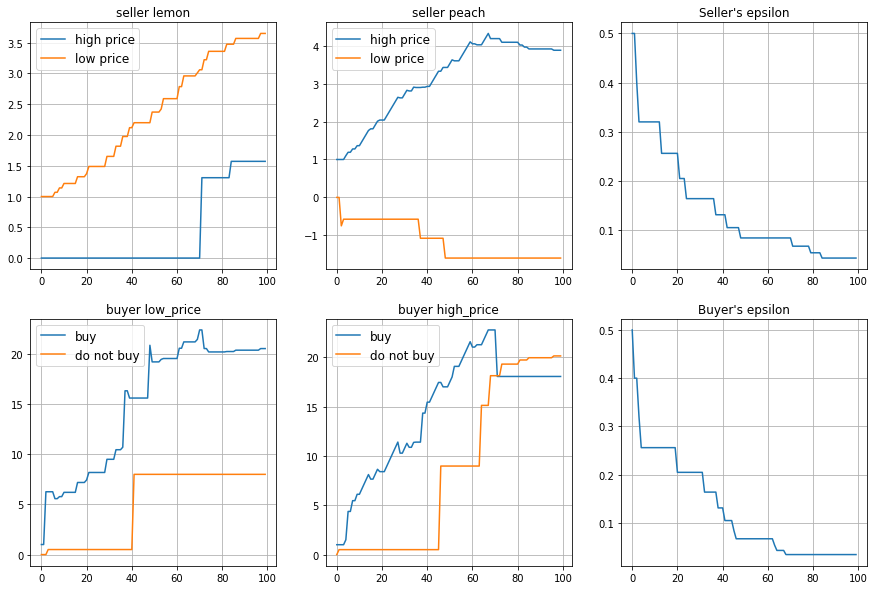

In [94]:
plot_results(result[0], result[3])

% заключенных сделок: 0.7


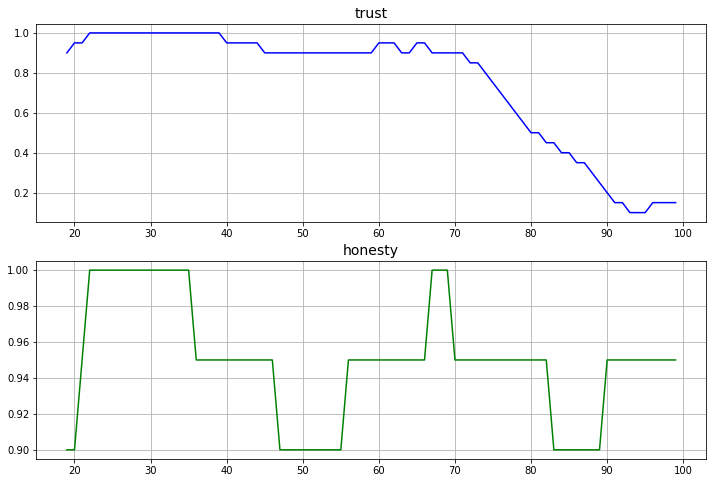

In [97]:
_ = plot_trust_honesty(result[1], rolling_num=20)

Ситуация, когда игроки начинают с честных стратегий, придерживаются их, после чего случайным образом один раз продавец продает лимон по высокой цене, покупатель покупает, после чего он больше не соглашается покупать по высокой цене, несмотря на то, что продавец продолжает вести себя честно.

### Пример 2

In [314]:
# parameters

# fully fair
qval_init_seller = {
    'lemon': [1, 0],
    'peach': [1, 0],
}

# fully trusting
qval_init_buyer = {
    'high_price': [0, 0],
    'low_price': [0, 0],
}

seller_lr = 0.01
buyer_lr = 0.01

n_iters = 1000
n_games = 100

seller_decay = 0.8
buyer_decay = 0.8

# lemon-peach, high_price-low_price, buy-not_buy

In [315]:
result = play_game(qval_init_seller, qval_init_buyer, seller_lr, buyer_lr, seller_decay, buyer_decay, 
                   n_iters, n_games)

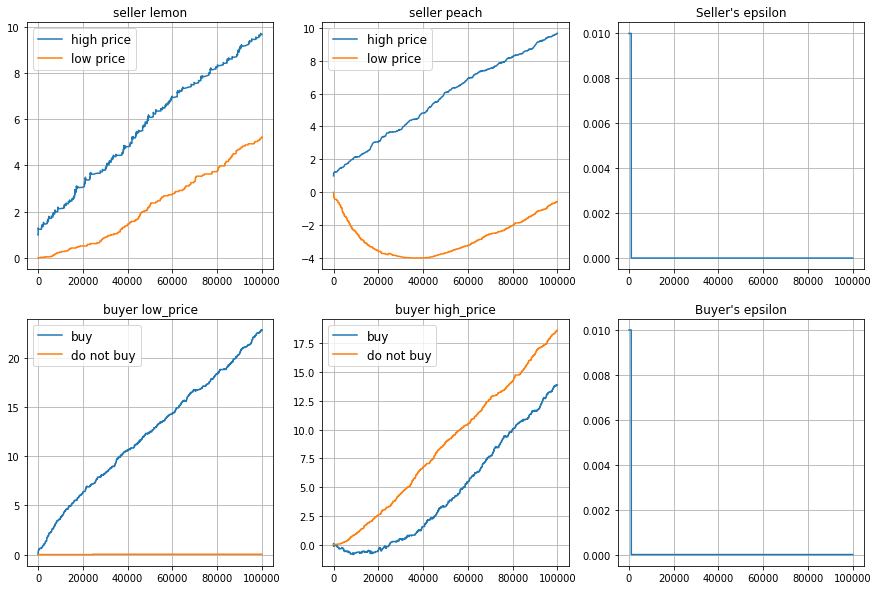

In [316]:
plot_results(result[0], result[3], n_iters * n_games)

% заключенных сделок: 0.25


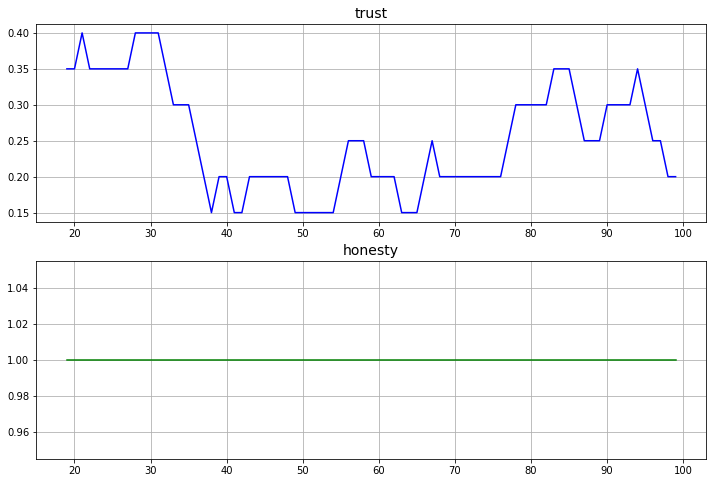

In [310]:
_ = plot_trust_honesty(result[1], rolling_num=20)

Ситуация, когда изначально у покупателя нечестная стратегия, тем не менее, так как стратегия покупателя - покупать только по низкой цене, продавец со временем начинает продавать лимоны по низкой цене.

### Пример 3

In [294]:
# parameters

# fully fair
qval_init_seller = {
    'lemon': [0, 1],
    'peach': [1, 0],
}

# fully trusting
qval_init_buyer = {
    'high_price': [0, 0],
    'low_price': [0, 0],
}

seller_lr = 0.7
buyer_lr = 0.7


n_iters = 100
n_games = 500

seller_decay = 0.5
buyer_decay = 0.5

# lemon-peach, high_price-low_price, buy-not_buy

In [301]:
result = play_game(qval_init_seller, qval_init_buyer, seller_lr, buyer_lr, seller_decay, buyer_decay, n_iters)

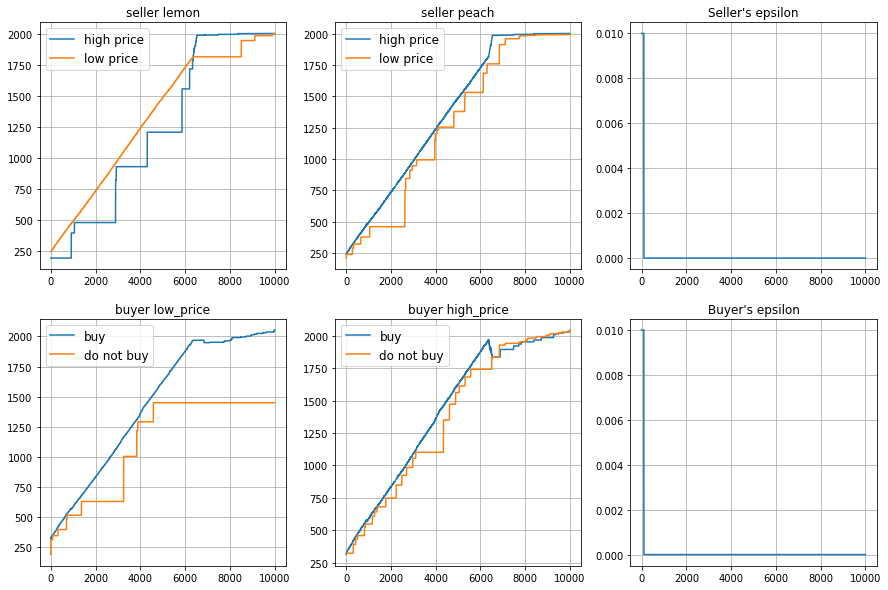

In [302]:
plot_results(result[0], result[3], n_iters * 100)

% заключенных сделок: 0.98


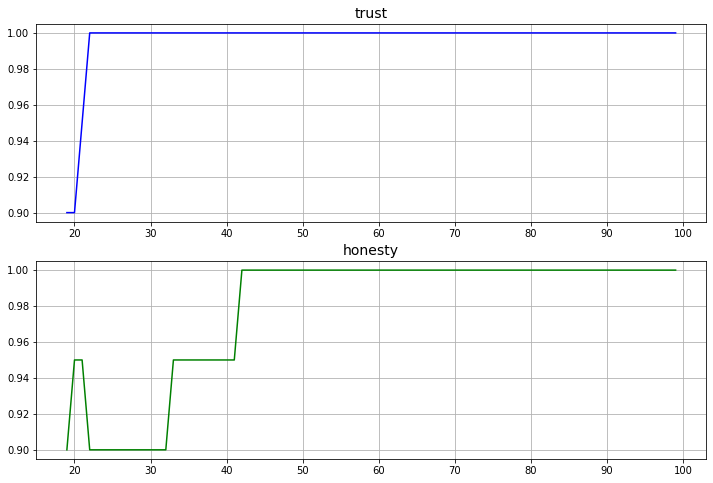

In [279]:
_ = plot_trust_honesty(result[1], rolling_num=20)

# Игра с реальными людьми

In [283]:
pd.read_excel('/Users/darapoludova/Downloads/190215_LPM.xlsx', sheet_name=2, header=None)

,0,1,2
0,session,1,"постоянные роли и партнеры, вероятность Л = 10%"
1,NaN,2,"постоянные роли и партнеры, вероятность Л = 25%"
2,Period,период,NaN
3,Subject,участник,NaN
4,Group,пара участников в периоде,NaN
5,Profit,выигрыш + 12,NaN
6,TotalProfit,суммарный выигрыш,NaN
7,Type,"1-продавец, 2 покупатель",NaN
8,CarType,"1-Лимон, 2-Персик",NaN
9,Offer,заявленная продавцом цена,NaN


In [287]:
data = pd.read_excel('/Users/darapoludova/Downloads/190215_LPM.xlsx', sheet_name=0, header=0)

In [292]:
data[:30]

,session,Period,Subject,Group,Profit,TotalProfit,T1_Offer_Start,T2_Offer_End,T3_Choice_Start,T4_Choice_End,T5_Res_Start,T6_Res_End,Type,CarType,Offer,Accept,TimeOKOfferOK,CurProfit
360,2,1,1,8,12.99,12.99,9976.575,0.000,9995.561,10021.551,10021.629,10025.482,2,2,11.01,1,0,0.99
361,2,1,2,6,12.00,12.00,9976.575,9992.534,9995.561,0.000,10021.629,10027.915,1,2,11.00,0,16,0.00
362,2,1,3,6,12.00,12.00,9976.575,0.000,9995.561,10003.501,10021.629,10026.371,2,2,11.00,0,0,0.00
363,2,1,4,2,13.00,13.00,9976.575,9983.549,9995.561,0.000,10021.629,10024.873,1,2,11.00,1,25,1.00
364,2,1,5,8,13.01,13.01,9976.575,9995.483,9995.561,0.000,10021.629,10025.778,1,2,11.01,1,13,1.01
365,2,1,6,9,13.00,13.00,9976.575,9983.127,9995.561,0.000,10021.629,10023.423,1,2,11.00,1,26,1.00
366,2,1,7,5,13.00,13.00,9976.575,9982.737,9995.561,0.000,10021.629,10025.170,1,2,11.00,1,26,1.00
367,2,1,8,1,13.00,13.00,9976.575,9992.815,9995.561,0.000,10021.629,10024.686,1,2,11.00,1,16,1.00
368,2,1,9,2,13.00,13.00,9976.575,0.000,9995.561,10003.220,10021.629,10025.669,2,2,11.00,1,0,1.00
369,2,1,10,4,12.50,12.50,9976.575,0.000,9995.561,10014.920,10021.629,10027.385,2,1,1.50,1,0,0.50


In [289]:
data = data[data['session'] == 2]

In [290]:
len(data)

360

In [291]:
data['Period']

360     1
361     1
362     1
363     1
364     1
       ..
715    20
716    20
717    20
718    20
719    20
Name: Period, Length: 360, dtype: int64